Reconstruction of 'ps_reg_03'
============
Considering, that ps_reg_03 appears to be one of the most (if not the most) predictive feature in the data set, determining how it is constructed could be an important step in building very predictive new features and improving models.
The closed form guesser of [Wolfram|Alpha](https://www.wolframalpha.com/), applied to some high precision values of ps_reg_03 reveals the following pattern:
$$
\text{ps_reg_03}=\frac{\sqrt{I}}{40},\quad \text{ with } I\in \mathbb{N^+}.
$$

In other words:
$$
I=\left(40*\text{ps_reg_03}\right)^2
$$

yields an integer. ps_reg_03 is therefore likely a categorical feature or a combination of combinatorical features.

Lets confirm this pattern for the full data set:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load training data
train = pd.read_csv('../input/train.csv')
# and remove nan values for now
train = train[train['ps_reg_03'] != -1]

In [3]:
train['ps_reg_03_int'] = train['ps_reg_03'].apply(lambda x: (40*x)**2)
train['ps_reg_03_int'].head(10)

0      825.0
1      939.0
3      540.0
4     1131.0
5     8706.0
6      610.0
7      590.0
8     1300.0
9     8587.0
10    1013.0
Name: ps_reg_03_int, dtype: float64

This looks promising and indeed all ps_reg_03_int are very close to an integer.

In [4]:
# Actually convert ps_reg_03_int to integer
train['ps_reg_03_int'] = train['ps_reg_03_int'].apply(np.round).apply(int)

As a cross-check, let us count the number of unique values of ps_reg_03 and the number of integer categories:

In [5]:
print("Unique values of ps_reg_03: ", len(train['ps_reg_03'].unique()))
print("Number of integer categories: ", len(train['ps_reg_03_int'].unique()))

Unique values of ps_reg_03:  5012
Number of integer categories:  5012


Now let's have a look at their distribution:

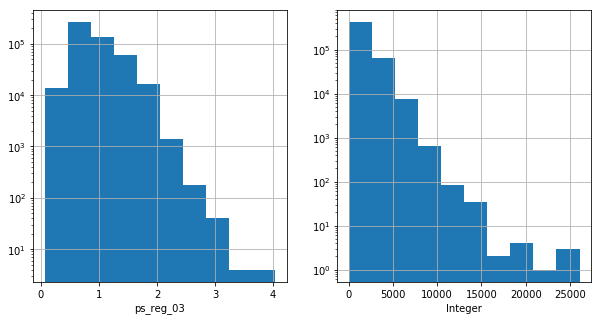

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(2): ax[i].set_yscale('log') #Set y-axis to log-scale
train['ps_reg_03'].hist(ax=ax[0])
ax[0].set_xlabel('ps_reg_03')
train['ps_reg_03_int'].hist(ax=ax[1])
ax[1].set_xlabel('Integer')

We can see that these integers are probably not the [municipalities of Brazil](https://en.wikipedia.org/wiki/Municipalities_of_Brazil) (1-5570), since values as large as 25000 exist. The skewness of the distribution supports this, although the data could have been sorted and municipalities relabeled.

It seems more likely that something like [Glimmung's interpretation](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41200) could be correct:

$$
\text{ps_reg_03}=\frac{\sqrt{27M + F}}{40},
$$

with F being the [federative unit of Brazil](https://en.wikipedia.org/wiki/Subdivisions_of_Brazil) (1-27) and M being the municipal number inside that administrative region, which can grow as large as a few hundred. Since there are only 27 federative units, the above equation yields a unique value for each combination of M and F.

For instance, the municipality 76 in unit 8 would yield the integer and ps_reg_03:

In [7]:
print("Integer: ", 27*76+8)
print("ps_reg_03: ", np.sqrt(27*76+8)/40)

Integer:  2060
ps_reg_03:  1.13468057179


This would explain the skewness, since lower municipalities are much more common (every federative unit has a municipality #1, but not #270).

Assuming for now, that the above equation is the correct interpretation, let's reconstruct M and F of each integer category:

In [8]:
def recon(reg):
    integer = int(np.round((40*reg)**2)) # gives 2060 for our example
    for f in range(28):
        if (integer - f) % 27 == 0:
            F = f
    M = (integer - F)//27
    return F, M

# Using the above example to test
ps_reg_03_example = 1.13468057179
print("Federative Unit (F): ", recon(ps_reg_03_example)[0])
print("Municipality (M): ", recon(ps_reg_03_example)[1])

Federative Unit (F):  8
Municipality (M):  76


Let's now apply this to the data set. The function above, despite being horribly inefficient, runs within a few seconds.

In [9]:
train['ps_reg_F'] = train['ps_reg_03'].apply(lambda x: recon(x)[0])
train['ps_reg_M'] = train['ps_reg_03'].apply(lambda x: recon(x)[1])
print(train[['ps_reg_03', 'ps_reg_F', 'ps_reg_M']].head(10))

    ps_reg_03  ps_reg_F  ps_reg_M
0    0.718070        15        30
1    0.766078        21        34
3    0.580948        27        19
4    0.840759        24        41
5    2.332649        12       322
6    0.617454        16        22
7    0.607248        23        21
8    0.901388         4        48
9    2.316652         1       318
10   0.795692        14        37


The administrative regions and municipalities are distributed as follows:

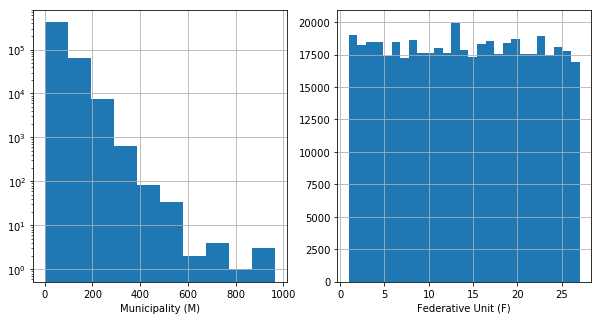

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_yscale('log') #Set y-axis to log-scale only for M
train['ps_reg_M'].hist(ax=ax[0])
ax[0].set_xlabel('Municipality (M)')
train['ps_reg_F'].hist(ax=ax[1], bins=27)
ax[1].set_xlabel('Federative Unit (F)')

The number of policy holders seems to be somewhat uniformly distributed over the federative units. The municipality is skewed right as expected.